In [88]:
#import dependencies
import csv
import pandas as pd
import numpy as np

In [89]:
train = df_samples = pd.read_excel(r'hepatitisBC.xlsx', engine='openpyxl')


In [90]:
import pandas as pd

# Assuming you have a DataFrame named 'train' with columns 'prognosis' and 'Symptoms'
# 'prognosis' column contains various disease names
# 'Symptoms' column contains the symptoms

# Calculate the total count of records
total_count = len(train)

# Get unique disease names from the 'prognosis' column
unique_diseases = train['prognosis'].unique()

# Create a dictionary to store prior probabilities for each disease
disease_prior_probabilities = {}

# Calculate the prior probability for each unique disease
for disease in unique_diseases:
    count_disease = len(train[train['prognosis'] == disease])
    prob_disease = count_disease / total_count
    disease_prior_probabilities[disease] = prob_disease



In [91]:
def sum_col(x):
    if  any(x)==1:
        return x.values.sum()

ndf = train.groupby('prognosis',as_index=False).agg(lambda x:(sum_col(x)))

In [92]:
ndf2=ndf.fillna(0)
df=ndf2.copy()

In [93]:

symptom_df=df

In [94]:


# Calculate the total count of cases for each symptom in both diseases
total_counts = symptom_df.sum(axis=0)[1:]

# Create a dictionary to store the conditional probabilities
p_Symptom_given_Disease = {}

# Calculate the conditional probabilities for each symptom given each disease
for disease in symptom_df['prognosis']:
    p_Symptom_given_Disease[disease] = {}
    for symptom in symptom_df.columns[1:]:
        if total_counts[symptom] != 0:
            p_Symptom_given_Disease[disease][symptom] = symptom_df[symptom_df['prognosis'] == disease][symptom].sum() / total_counts[symptom]

# Convert to the desired dictionary format
output_dict = {}
for disease in symptom_df['prognosis']:
    output_dict[disease] = p_Symptom_given_Disease[disease]



In [95]:
import numpy as np
import networkx as nx
from pyvis.network import Network
import random
# Create dictionaries for P(Disease) and P(Symptom | Disease)


disease_symptom_clusters = output_dict

# Create a graph
G = nx.Graph()

# Define a color mapping function for diseases
def get_random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Calculate P(Disease | Symptoms) using Naive Bayes formula for all diseases
results = {}
sum_prob = 0.0  # To calculate the sum of probabilities for normalization

for disease in disease_prior_probabilities:
    query_prob = disease_prior_probabilities[disease]
    valid_symptoms = {
        symptom: disease_symptom_clusters[disease][symptom]
        for symptom in disease_symptom_clusters[disease] if disease_symptom_clusters[disease][symptom] != 0
    }
    
    if valid_symptoms:
        for symptom, symptom_prob in valid_symptoms.items():
            query_prob *= symptom_prob
        results[disease] = query_prob
        sum_prob += query_prob

# Normalize the probabilities for diseases
for disease, probability in results.items():
    results[disease] = probability / sum_prob

# Add disease nodes with prior probabilities and assign colors dynamically
disease_colors = {}
for disease, probability in disease_prior_probabilities.items():
    disease_color = get_random_color()
    disease_colors[disease] = disease_color
    label = f"{disease}\nPrior: {probability:.3f}\nPosterior: {results[disease]:.4f}"
    G.add_node(label, color=disease_color)

# Add symptom nodes with conditional probabilities and assign colors based on associated disease colors
for disease, symptoms in disease_symptom_clusters.items():
    disease_color = disease_colors[disease]
    valid_symptoms = {
        symptom: symptom_prob
        for symptom, symptom_prob in symptoms.items() if symptom_prob != 0
    }
    
    for symptom, probability in valid_symptoms.items():
        label = f"{symptom}\n{probability:.3f}"
        G.add_node(label, color=disease_color)

# Add edges between disease nodes and associated symptom nodes
for disease, symptoms in disease_symptom_clusters.items():
    for symptom, symptom_prob in symptoms.items():
        if symptom_prob != 0:
            disease_label = f"{disease}\nPrior: {disease_prior_probabilities[disease]:.3f}\nPosterior: {results[disease]:.4f}"
            symptom_label = f"{symptom}\n{symptom_prob:.3f}"
            G.add_edge(disease_label, symptom_label)

# Create a Network object
nt = Network(notebook=True, width="100%", height="800px")

# Show the graph
nt.from_nx(G)
nt.show("disease_symptom_graph.html")


disease_symptom_graph.html


In [96]:
import numpy as np
import networkx as nx
from pyvis.network import Network
import random
# Create dictionaries for P(Disease) and P(Symptom | Disease)
#disease_prior_probabilities = joint_probabilities
#disease_prior_probabilities= disease_prior_probabilities
disease_symptom_clusters = output_dict

# Symptoms in evidence
evidence_symptoms = ['itching', 'yellowing_of_eyes']
#evidence_symptoms = ['itching']

# Create a graph
G = nx.Graph()

# Define a color mapping function for diseases
def get_random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Calculate P(Disease | Symptoms) using Naive Bayes formula for all diseases based on evidence symptoms
results = {}
sum_prob = 0.0  # To calculate the sum of probabilities for normalization

for disease in disease_prior_probabilities:
    query_prob = disease_prior_probabilities[disease]
    valid_symptoms = {
        symptom: disease_symptom_clusters[disease][symptom]
        for symptom in evidence_symptoms if symptom in disease_symptom_clusters[disease] and disease_symptom_clusters[disease][symptom] != 0
    }
    
    if valid_symptoms:
        for symptom, symptom_prob in valid_symptoms.items():
            query_prob *= symptom_prob
        results[disease] = query_prob
        sum_prob += query_prob

# Normalize the probabilities for diseases
for disease, probability in results.items():
    results[disease] = probability / sum_prob

# Calculate the highest posterior probability
highest_posterior = max(results.values())



# Add disease nodes with prior probabilities and assign colors dynamically
disease_colors = {}
for disease, probability in disease_prior_probabilities.items():
    disease_color = get_random_color()
    disease_colors[disease] = disease_color
    label = f"{disease}\nPrior: {probability:.3f}\nPosterior: {results[disease]:.4f}"
    G.add_node(label, color=disease_color)

# Add symptom nodes with conditional probabilities and assign colors based on associated disease colors
for disease, symptoms in disease_symptom_clusters.items():
    if any(symptom in evidence_symptoms for symptom in symptoms):
        disease_color = disease_colors[disease]
        valid_symptoms = {
            symptom: symptom_prob
            for symptom, symptom_prob in symptoms.items() if symptom in evidence_symptoms and symptom_prob != 0
        }

        for symptom, probability in valid_symptoms.items():
            label = f"{symptom}\n{probability:.3f}"
            G.add_node(label, color=disease_color)

# Add edges between disease nodes and associated symptom nodes
for disease, symptoms in disease_symptom_clusters.items():
    if any(symptom in evidence_symptoms for symptom in symptoms):
        for symptom, symptom_prob in symptoms.items():
            if symptom in evidence_symptoms and symptom_prob != 0:
                disease_label = f"{disease}\nPrior: {disease_prior_probabilities[disease]:.3f}\nPosterior: {results[disease]:.4f}"
                symptom_label = f"{symptom}\n{symptom_prob:.3f}"
                G.add_edge(disease_label, symptom_label)

# Create a Network object
nt = Network(notebook=True, width="100%", height="800px")

# Show the graph
nt.from_nx(G)
nt.show("disease_symptom_graph.html")


disease_symptom_graph.html


In [97]:

import time
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import time

%matplotlib inline

from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling
from pgmpy.sampling import GibbsSampling
import networkx as nx

In [98]:
cleanup_nums = {"prognosis":     {"Hepatitis B": 0, "Hepatitis C": 1}}

In [99]:
train2 = train.replace(cleanup_nums)

In [100]:
architecture= [("itching", "prognosis"),
                   
                      
                       ("fatigue", "prognosis"),
                       ("lethargy", "prognosis"),
                    
                       ("yellowish_skin", "prognosis"),
                       ("dark_urine", "prognosis"),
                       ("nausea", "prognosis"),
                       ("loss_of_appetite", "prognosis"),
                       ("abdominal_pain", "prognosis"),
                     
                     
                       ("yellow_urine", "prognosis"),
                       ("yellowing_of_eyes", "prognosis"),
                      
                       ("malaise", "prognosis"),
             
                       ("family_history", "prognosis"),
                       ("receiving_blood_transfusion", "prognosis"),
                       ("receiving_unsterile_injections", "prognosis")]

In [101]:
model = BayesianModel(architecture)

In [103]:
nodes = list(model.nodes())
edges = list(model.edges())



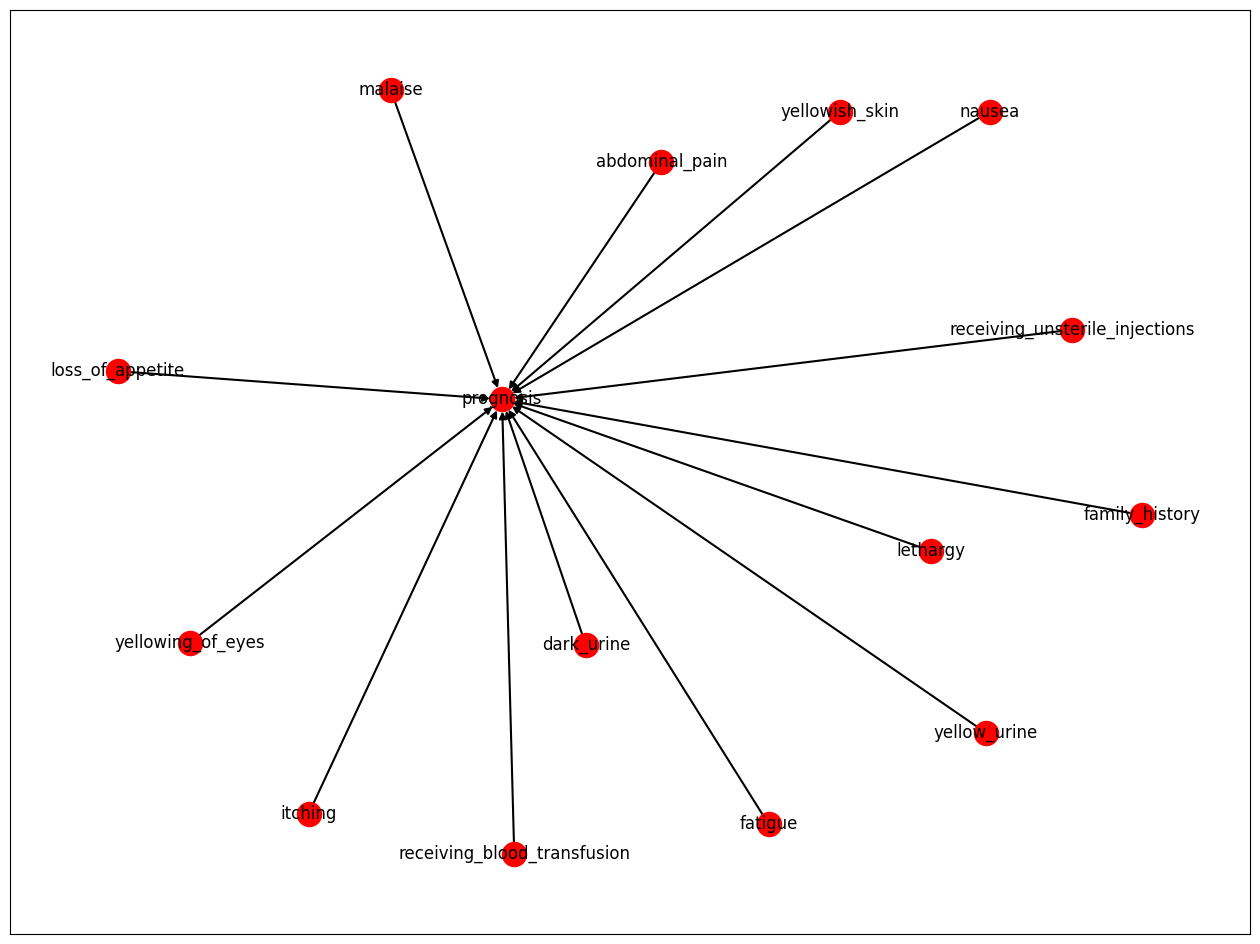

In [104]:
DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (16,12))
pos = nx.spring_layout(DAG) 

nx.draw_networkx_nodes(DAG, pos = pos, node_color = 'red')
nx.draw_networkx_labels(DAG, pos = pos)
nx.draw_networkx_edges(DAG, pos = pos, edge_color = 'black', width = 1.5, arrows = True)

plt.show()

In [105]:
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML(""))

model.cpds = []
model.fit(  data=train2
          , estimator=BayesianEstimator
          , prior_type="BDeu"
          , equivalent_sample_size=10
          ,complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of itching:
+------------+-------+
| itching(0) | 0.524 |
+------------+-------+
| itching(1) | 0.476 |
+------------+-------+ 

CPT of prognosis:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [106]:
from pgmpy.inference import VariableElimination
inference =VariableElimination(model)

In [107]:

BMS_inference = BayesianModelSampling(model)
GS_inference = GibbsSampling(model)



In [108]:
# Dictionary of the discrete value to let the method access at CPTs
value_dict = {
    True: 1,
    False: 0,
    '0-15': 0,
    '16-45': 1,
    '46-90': 2,
    '1': 0,
    '2': 1,
    '3': 2,
    '4': 3,
    '5': 4,
    'sv': 0,
    '<=5': 1,
    '5.5-6.5': 2,
    '7-9.5': 3,
    '>=10': 4
}

def discretization(x, value):
    '''
    Function that helps to discretize for likelihood weighting and rejection sampling
    x     : unknown variable
    value : value to analyze for the unknown variable based on the value of the query variable
    '''
    if x == value_dict[value]:
        return 1
    else:
        return 0

def prob_LW(samples, variable, query_value):
    '''
    Function that calculates the likelihood weighting probability
    samples     : sample from which to extract the probability value
    variable    : variable of the query
    query_value : value of the query variable
    '''
    discretize = np.vectorize(discretization)
    samples_thresholded = discretize(samples[variable], query_value)
    return round(np.sum(np.dot(samples_thresholded, samples['_weight'])) / np.sum(samples['_weight']), 2)

def prob_RS(samples, variable, query_value):
    '''
    Function that calculates the rejection sampling probability
    samples     : sample from which to extract the probability value
    variable    : variable of the query
    query_value : value of the query variable
    '''
    discretize = np.vectorize(discretization)
    samples_rejection = discretize(samples[variable], query_value)
    return np.mean(samples_rejection, axis=0)

def get_state_index(var, var_val):
    '''
    Function that returns the index of a given value for a variable
    '''
    return inference.query([var], show_progress=False).state_names.get(var).index(var_val)

def prob_GS(samples, query_variable, query_evidence, query_value):
    """
    Computes the probability of Gibbs Sampling given the samples
    it will call a pgmpy query function building the string for the requested query
    """
    gs_query = ""
    for evidence, value in query_evidence.items():
        gs_query += evidence + " == " + str(get_state_index(evidence, value))
        if evidence != list(query_evidence.keys())[-1]:
            # add the '&' except for the last element
            gs_query += " & "

    # check denominator to avoid division by 0
    if samples.query(gs_query).shape[0] == 0:
        return 0.0
    else:
        return (samples.query(query_variable[0] + " == " + str(get_state_index(query_variable[0], query_value)) + " & " + gs_query).shape[0] 
              / samples.query(gs_query).shape[0])

#Absolute error function
def absolute_error(exact_value, approx_value):
    '''
    Function that computes the absolute error between the approximated and exact probabilities
    exact_value   : reference probability value of the query
    approx_value  : approximate probability value of the query
    '''
    return np.absolute(exact_value - approx_value)

#Relative error function
def relative_error(exact_value, approx_value):
    '''
    Function that computes the absolute error between the approximated and exact probabilities
    exact_value   : reference probability value of the query
    approx_value  : approximate probability value of the query
    '''
    return np.absolute(((exact_value - approx_value) / approx_value))

def query_preprocessing(query_variable, query_evidence, query_value):
    '''
    Function that returns the processed query variable, evidence to adapt them to the methods
    of likelihood weighting and rejection sampling

    query_variable: list with one unknown variable of the query
    query_evidence: dict representing the evidence of the query
    query_value   : value of the query var to find in the query
    '''
    evidence = []

    for (evidence_var, evidence_value) in query_evidence.items():
        state = State(evidence_var, evidence_value)
        evidence.append(state)

    default_query_prob = highest_posterior  # Replace this with your desired default value
    query_prob = default_query_prob
    variables = query_variable[0]

    return query_prob, evidence, variables


def run_experiment(sample_size,query_variable,query_evidence,query_value):
  '''
  Function that return the result of a sampling experiment using likelihood weighting,
  rejection sampling and Gibbs sampling

  sample_size    : size of the sample for the experiment
  query_variable : list with one unknown variable of the query
  query_evidence : dict representing the evidence of the query
  query_value:   : value of the query var to find in the query
  '''

  #Rounding precision
  precision = 3

  #Preprocessing for the LW and RS methods
 
  query_prob,evidence,variable = query_preprocessing(query_variable,query_evidence,query_value)
 

  t0_LW = time.time()
  samples_LW = BMS_inference.likelihood_weighted_sample(evidence = evidence, size=sample_size, return_type='recarray')
  approx_prob_LW = prob_LW(samples_LW,variable,query_value)
  time_LW = round(time.time() - t0_LW, precision)

  t0_RS = time.time()
  samples_RS = BMS_inference.rejection_sample(evidence=evidence, size=sample_size, return_type='recarray',show_progress=False)
  approx_prob_RS = prob_RS(samples_RS,variable,query_value)
  time_RS = round(time.time() - t0_RS, precision)


  t0_GS = time.time()
  samples_GS = GS_inference.sample(size=sample_size, seed=37)
  approx_prob_GS = prob_GS(samples_GS,query_variable,query_evidence,query_value)
  time_GS = round(time.time() - t0_GS, precision)

  # Return results
  return np.array([(sample_size,query_prob,
                        approx_prob_RS, absolute_error(query_prob,approx_prob_RS), relative_error(query_prob,approx_prob_RS),time_RS,
                        approx_prob_LW, absolute_error(query_prob,approx_prob_LW), relative_error(query_prob,approx_prob_LW),time_LW,
                        approx_prob_GS, absolute_error(query_prob,approx_prob_GS), relative_error(query_prob,approx_prob_GS),time_GS)],
                      dtype=[('sample_size', '<i8'),('query_prob', '<f8'),  
                            ('approx_prob_RS', '<f8'),('abs_error_RS', '<f8'),('rel_error_RS', '<f8'),('time_RS','<f8'),
                            ('approx_prob_LW', '<f8'),('abs_error_LW', '<f8'),('rel_error_LW', '<f8'),('time_LW','<f8'),
                            ('approx_prob_GS', '<f8'),('abs_error_GS', '<f8'),('rel_error_GS', '<f8'),('time_GS','<f8')])
          
#Query in approximate inference
def approximate_inference(q,query_var,query_evidence,query_value,starting_size=2.5,final_size=5,experiments=10):  
  '''
  Function that create the result of the different approximate inference methods using
  different sample size values

  query_var:     : list with one unknown variable of the query
  query_evidence : dict representing the evidence of the query
  query_value:   : value of the query var to find in the query
  starting_size=2 : exponent of the number of start sample points that are 10^(starting_size)
  final_size=5    : exponent of the number of final sample points that are 10^(final_size)
  experiments=10 : number of sampling experiments
  '''
  results = np.array([],dtype=[('sample_size', '<i8'),('query_prob', '<f8'),('approx_prob_RS', '<f8'),
                               ('abs_error_RS', '<f8'),('rel_error_RS', '<f8'),('time_RS', '<f8'),
                               ('approx_prob_LW', '<f8'),('abs_error_LW', '<f8'),('rel_error_LW', '<f8'),('time_LW','<f8'),
                               ('approx_prob_GS', '<f8'),('abs_error_GS', '<f8'),('rel_error_GS', '<f8'),('time_GS','<f8')])

  for size in np.logspace(starting_size, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size,query_var,query_evidence,query_value))

   

  

  globals()[f"query{q}"]=pd.DataFrame(results)
  globals()[f"query{q}"].to_csv(f"query{q}"+'.csv')
  # display table
  print("\nResults during sampling:")
  display(pd.DataFrame(results))
  print("\n")
  # show plots
  plot_results(results,query_evidence,query_var,query_value)

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Set the desired figure size
figure_width = 15  # You can adjust this value based on your needs
figure_height = 10  # You can adjust this value based on your needs

# Adjust font sizes globally
plt.rcParams.update({'font.size': 14, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

def plot_results(results, query_evidence, query_variable, query_value):
    '''
    Function to plot the result of the approximate inference
    '''
    query_prob, evidence, var = query_preprocessing(query_variable, query_evidence, query_value)
    
    plt.figure(figsize=(figure_width, figure_height))  # Set the figure size here
    
    plt.grid(True)
    plt.title("Approximate probability values", fontsize=16)
    LWCplot, = plt.semilogx(results['sample_size'], results['approx_prob_LW'], 'go--', label="Likelihood Weighting", markersize=8)
    RSCplot, = plt.semilogx(results['sample_size'], results['approx_prob_RS'], 'bo--', label="Rejection Sampling", markersize=8)
    GSCplot, = plt.semilogx(results['sample_size'], results['approx_prob_GS'], 'mo--', label="Gibbs Sampling", markersize=8)
    VECplot, = plt.semilogx(results['sample_size'], query_prob * np.ones(results.size), 'r', label="reference value")
    plt.xlabel("Sample size")
    plt.ylabel("Approximate probability value")
    plt.legend(handles=[LWCplot, RSCplot, GSCplot, VECplot], loc='upper right')
    plt.tight_layout()
    
    # Save the plot with desired dimensions
    plt.savefig('output_plot1.png', dpi=300)  # You can adjust the filename and dpi as needed
    plt.show()

    plt.figure(figsize=(figure_width, figure_height))  # Set the figure size here
    
    plt.grid(True)
    plt.title("Trend of absolute error", fontsize=16)
    ELWCplot, = plt.semilogx(results['sample_size'], results['abs_error_LW'], 'go--', label="Likelihood Weighting", markersize=8)
    ERSCplot, = plt.semilogx(results['sample_size'], results['abs_error_RS'], 'bo--', label="Rejection Sampling", markersize=8)
    EGSCplot, = plt.semilogx(results['sample_size'], results['abs_error_GS'], 'mo--', label="Gibbs Sampling", markersize=8)
    plt.xlabel("Sample size")
    plt.ylabel("Absolute error value")
    plt.legend(handles=[ELWCplot, ERSCplot, EGSCplot], loc='upper right')
    plt.tight_layout()
    
    # Save the plot with desired dimensions
    plt.savefig('output_plot2.png', dpi=300)  # You can adjust the filename and dpi as needed
    plt.show()

    plt.figure(figsize=(figure_width, figure_height))  # Set the figure size here
    
    plt.grid(True)
    plt.title("Trend of relative error", fontsize=16)
    ELWCplot, = plt.semilogx(results['sample_size'], results['rel_error_LW'], 'go--', label="Likelihood Weighting", markersize=8)
    ERSCplot, = plt.semilogx(results['sample_size'], results['rel_error_RS'], 'bo--', label="Rejection Sampling", markersize=8)
    EGSCplot, = plt.semilogx(results['sample_size'], results['rel_error_GS'], 'mo--', label="Gibbs Sampling", markersize=8)
    plt.xlabel("Sample size")
    plt.ylabel("Relative error value")
    plt.legend(handles=[ELWCplot, ERSCplot, EGSCplot], loc='upper right')
    plt.tight_layout()
    
    # Save the plot with desired dimensions
    plt.savefig('output_plot3.png', dpi=300)  # You can adjust the filename and dpi as needed
    plt.show()

    plt.figure(figsize=(figure_width, figure_height))  # Set the figure size here
    
    plt.grid(True)
    plt.title("Trend of the sampling time", fontsize=16)
    TLWplot, = plt.semilogx(results['sample_size'], results['time_LW'], 'go--', label="Likelihood Weighting", markersize=8)
    TRSplot, = plt.semilogx(results['sample_size'], results['time_RS'], 'bo--', label="Rejection Sampling", markersize=8)
    TGSplot, = plt.semilogx(results['sample_size'], results['time_GS'], 'mo--', label="Gibbs Sampling", markersize=8)
    plt.xlabel("Sample size")
    plt.ylabel("Seconds")
    plt.legend(handles=[TLWplot, TRSplot, TGSplot], loc='upper right')
    plt.tight_layout()
    
    # Save the plot with desired dimensions
    plt.savefig('output_plot4.png', dpi=300)  # You can adjust the filename and dpi as needed
    plt.show()





100%|███████████████████████████████████████████████████████████████████████████| 99999/99999 [02:07<00:00, 782.22it/s]



Results during sampling:


sample_size  query_prob  approx_prob_RS  abs_error_RS  rel_error_RS  \
0          316    0.526316        0.531646      0.005330      0.010025   
1          599    0.526316        0.517529      0.008787      0.016978   
2         1136    0.526316        0.529930      0.003614      0.006819   
3         2154    0.526316        0.489786      0.036529      0.074582   
4         4084    0.526316        0.488002      0.038314      0.078512   
5         7742    0.526316        0.502454      0.023862      0.047490   
6        14677    0.526316        0.500307      0.026009      0.051986   
7        27825    0.526316        0.497969      0.028346      0.056924   
8        52749    0.526316        0.498531      0.027785      0.055734   
9       100000    0.526316        0.498570      0.027746      0.055651   

   time_RS  approx_prob_LW  abs_error_LW  rel_error_LW  time_LW  \
0    3.927            0.52      0.006316      0.012146    3.553   
1    4.172            0.50      0.026316      0.052632    4.202   
2    3.907            0.49      0.036316      0.074114    3.880   
3    4.415            0.52      0.006316      0.012146    4.206   
4    5.455            0.51      0.016316      0.031992    5.036   
5    5.120            0.50      0.026316      0.052632    3.741   
6    3.863            0.51      0.016316      0.031992    3.771   
7    4.337            0.50      0.026316      0.052632    4.322   
8    4.422            0.50      0.026316      0.052632    5.054   
9    5.236            0.50      0.026316      0.052632    5.054   

   approx_prob_GS  abs_error_GS  rel_error_GS  time_GS  
0             1.0      0.473684      0.473684   27.101  
1             1.0      0.473684      0.473684   26.266  
2             1.0      0.473684      0.473684   32.663  
3             1.0      0.473684      0.473684   30.888  
4             1.0      0.473684      0.473684   32.061  
5             1.0      0.473684      0.473684   38.361  
6             1.0      0.473684      0.473684   47.785  
7             1.0      0.473684      0.473684   67.236  
8             1.0      0.473684      0.473684   96.443  
9             1.0      0.473684      0.473684  154.831

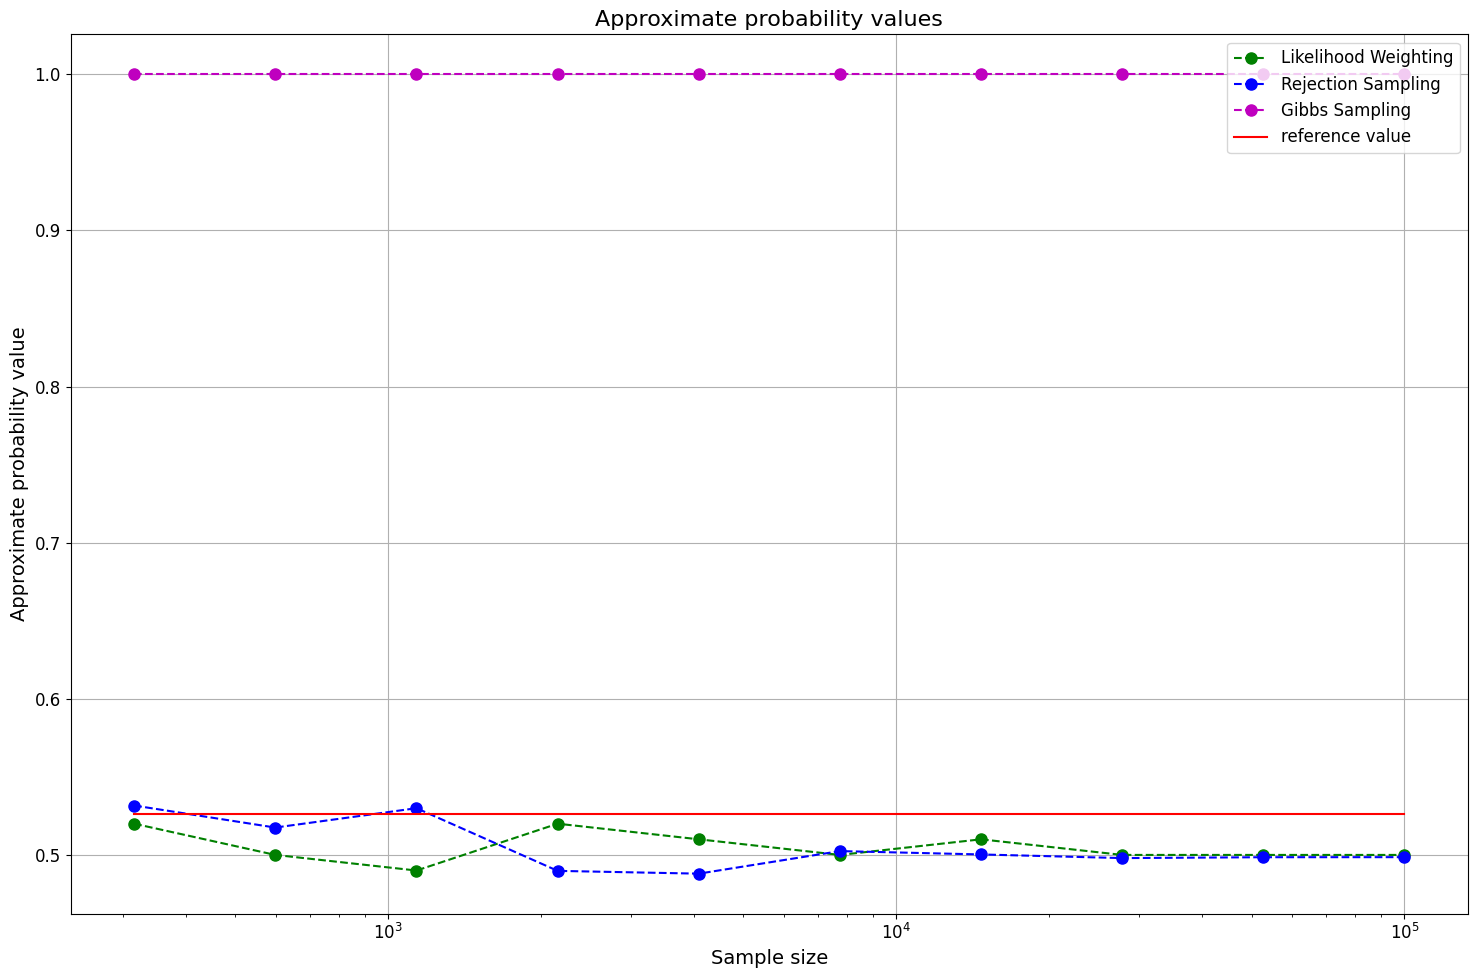

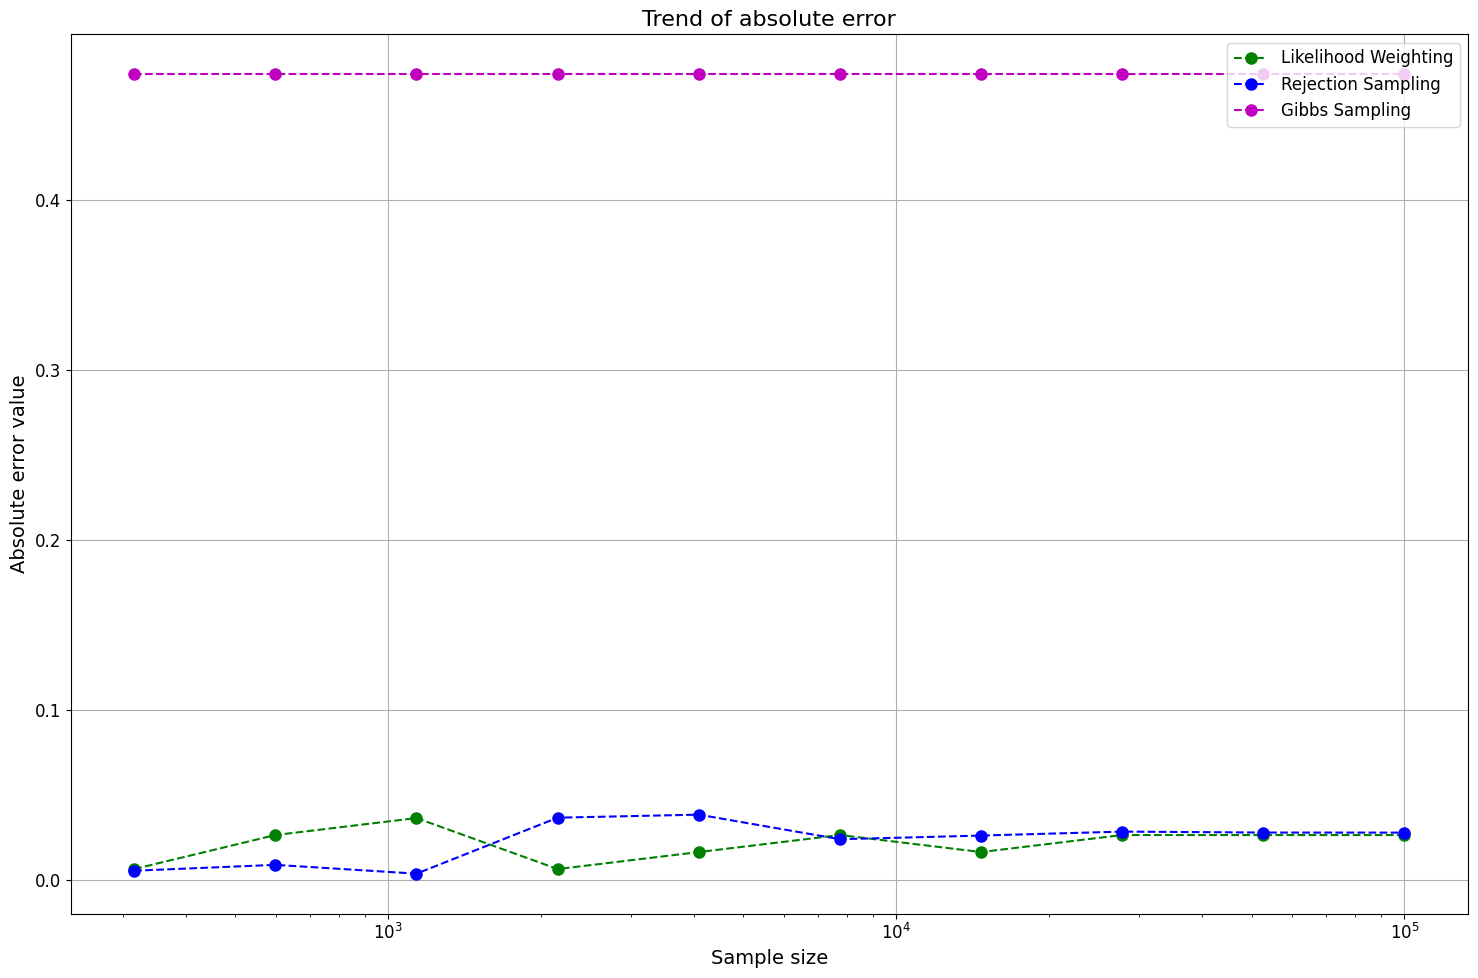

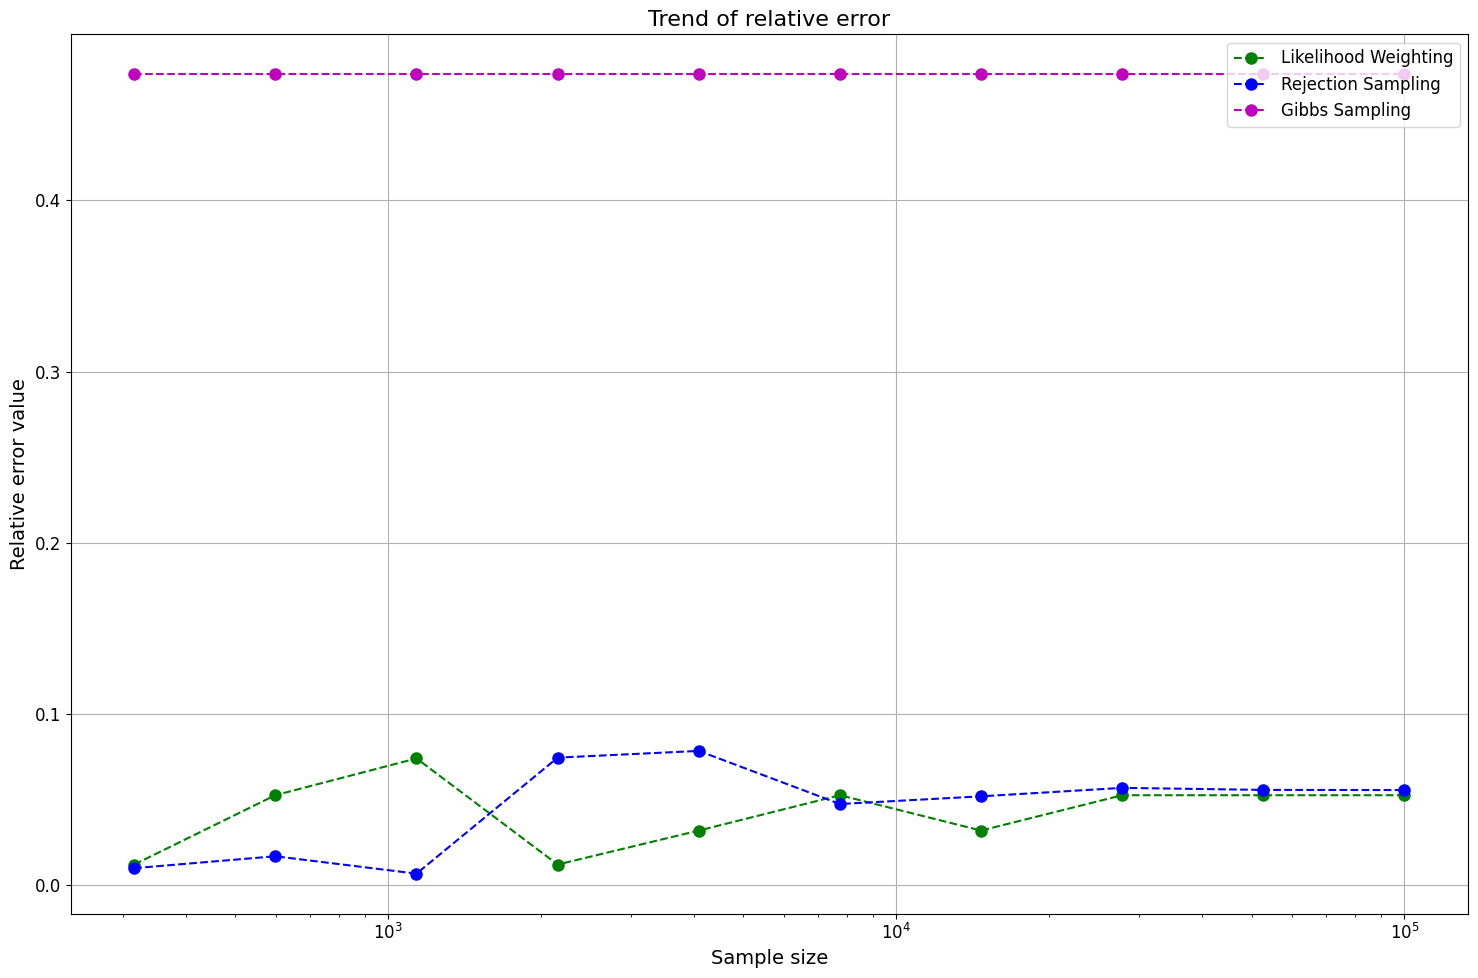

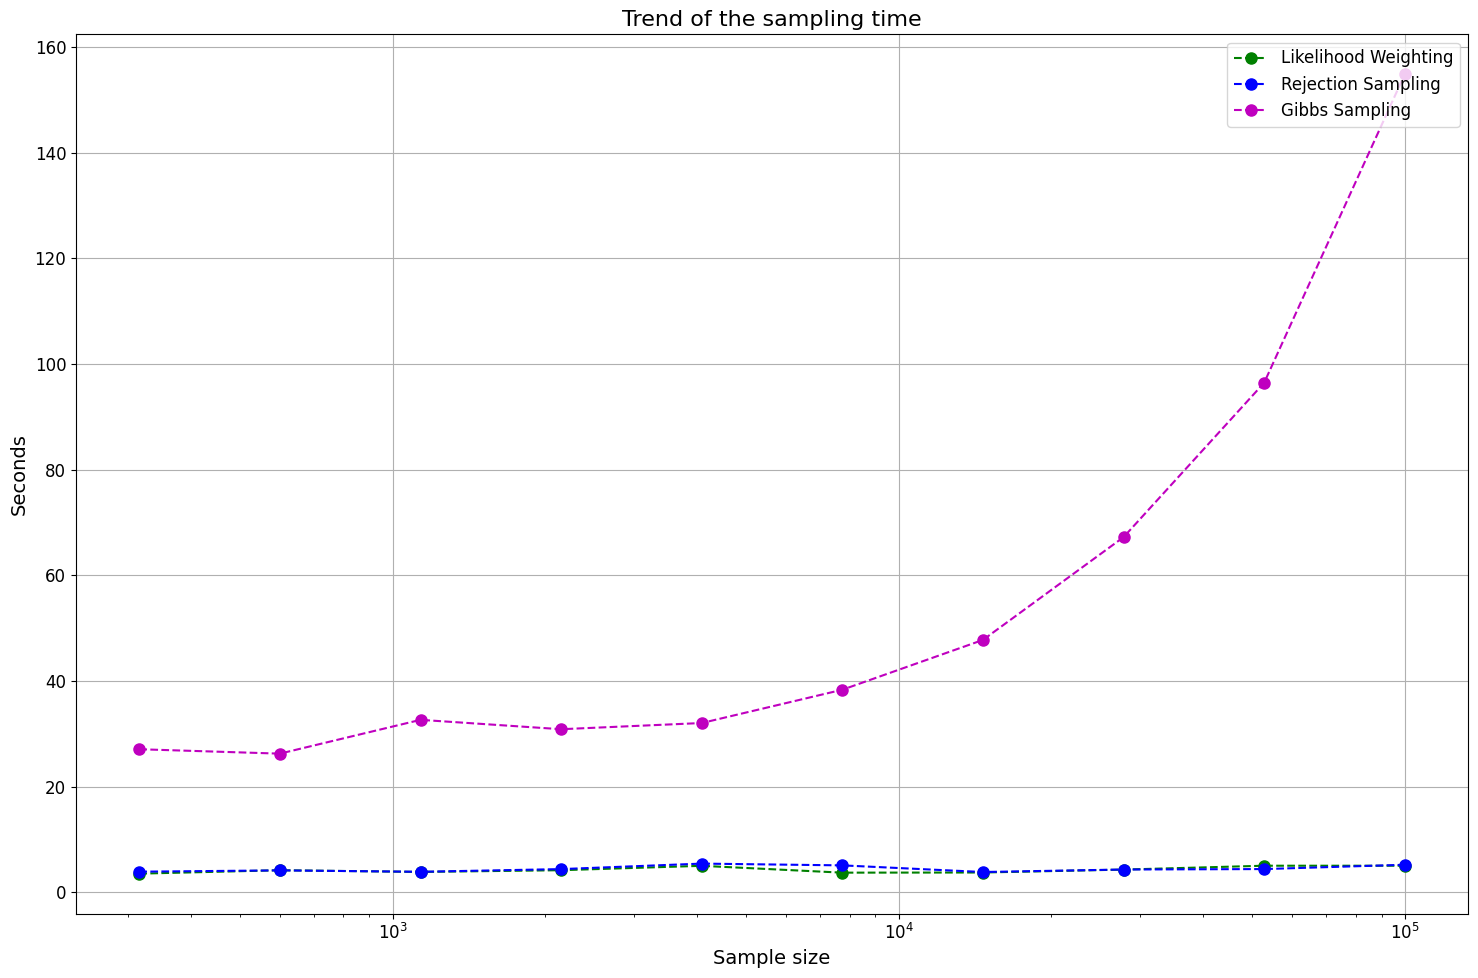

In [111]:
approximate_inference(1,['prognosis'],{'fatigue':1},True)